# Data loading

Training data is distributed in 3 different folders (set a, b and c).
Each file has its raw image (.mhd), lung mask (\_lm.mhd), and fissure mask (\_fm.mhd).

In [1]:
import os, random
import ntpath
import SimpleITK
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np


In [2]:
workdir = '/projects/0/ismi2018/FINALPROJECTS/CHESTCT_FISSURE_INTEGRITY/'
train_A_images = os.path.join(workdir, 'set-a')
train_B_images = os.path.join(workdir, 'set-b')
train_C_images = os.path.join(workdir, 'set-c')

a25_lm.mhd
(215, 285, 528)


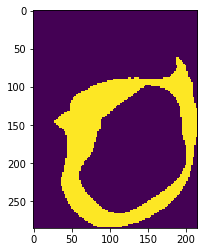

In [4]:
#Print one file:
case = os.path.join(train_A_images, random.choice(os.listdir(train_A_images)))
case_filename = os.path.splitext(ntpath.basename(case))[0] + '.mhd'
img = SimpleITK.ReadImage(train_A_images+ '/' + case_filename)

piece = SimpleITK.GetArrayViewFromImage(img)[50,:,:] #<-- Specify a number for the z-index slice
print(case_filename)
print(img.GetSize())
plt.imshow(piece)


In [5]:
''' Helper function '''
def load_unique_image_names(folder):
    
    uniqueimglist = []
    for file in os.listdir(folder):
        file = file.replace(".mhd", "")
        file = file.replace("_lm", "")
        file = file.replace("_fm", "")
        file = file.replace(".zraw", "")
        if ".csv" not in file:
            uniqueimglist.append(file)
    uniqueimglist = list(set(uniqueimglist))
    return uniqueimglist


''' Load training data from a folder'''
def load_training_set(folder):
    fileList = load_unique_image_names(folder)
    
    trainSet = []
    for file in fileList:
        filePath = folder + '/' + file
        image = lungMask = fissureMask = None
        try:
            image = SimpleITK.ReadImage(filePath + '.mhd')
            lungMask = SimpleITK.ReadImage(filePath + '_lm.mhd')
            fissureMask = SimpleITK.ReadImage(filePath + '_fm.mhd')
            label = file[0]
            trainSet.append({'name': file, 
                         'image': image, 
                         'lungmask': lungMask,
                         'fissuremask': fissureMask,
                         'label': label})
        except :
            print("Error reading file: " + file)
            
    return trainSet

def get_exact_csv_set(folder, label):
    return pd.read_csv(folder + '/LUT-' + label + '.csv')
    


In [6]:
print("Loading train set...")
training = load_training_set(train_A_images)
training.extend(load_training_set(train_B_images))
training.extend(load_training_set(train_C_images))
training = pd.DataFrame(training)
print("Done loading!")

Loading train set...
Done loading!


Accessing the LUT csv files to attach the exact percentages to the training set:

In [7]:

exact = get_exact_csv_set(train_A_images, 'a') # 60
exact = exact.append(get_exact_csv_set(train_B_images, 'b'), ignore_index=True) # 38
exact = exact.append(get_exact_csv_set(train_C_images, 'c'), ignore_index=True) # 102
exact = exact.rename(columns={'Fissure_completeness': 'completeness'})

print("exact size: ", exact.size)
print("training size: ", training.size)

'''
emptyList = []
trainList = []
for el in training['name']:
    trainList.append(el)
    if el not in exact['New ID']:
        emptyList.append(el)
print(sorted(emptyList))
print(sorted(trainList))
print("Do the csv files represent the whole training set?")
print(sorted(trainList)== sorted(emptyList) )

exact['New ID'].iloc[31]
'''


# Join the csv set with the training set
training = pd.merge(training, exact, left_on='name', right_on='New ID')
training = training.drop('New ID', 1)


exact size:  200
training size:  500


In [8]:
training.head(5)

,fissuremask,image,label,lungmask,name,completeness
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-126, -131, -72, -69, -154, -116, -61, -101, ...",a,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",a08,57.0327
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-105, -124, -132, -140, -122, -49, -51, -122,...",a,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",a04,46.2267
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-131, -147, -146, -78, -41, -99, -81, -92, -8...",a,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",a25,77.9893
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[9, 37, 93, 6, 2, -62, -96, -14, 53, -59, -2, ...",a,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",a18,72.2658
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[142, 88, 59, 40, 45, 55, 74, 20, 108, 131, 76...",a,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",a00,20.2700


## Accessing the data

We attached the labels LUT-a.csv (etc...) to the training data in order to make it into a regression problem. Now, we would like to save this dataframe to file. Unfortunately, this can't be done, as the image elements aren't pickle-able (_Python can't pickle swigpy objects_).



- (Data) Raw images can be accessed by utilizing `training['image'].values`. This will return an array with the SimpleITK images.
- (Label) Classification labels _(a,b,c)_ can be obtained by `training['label'].values`.
- (Label) Regression labels _Fissure completeness percentage (%)_ can be obtained by `training['completeness'].values`.

Save the training set to file

*Actually can't be done, as it can't pickle swigpy objects..*

In [9]:
#store = pd.HDFStore('database.h5')
#store['trainingset'] = training

In [10]:
#training.to_pickle('./train-data.pkl')

Completeness:  46.2267


array([0, 2, 4], dtype=uint8)

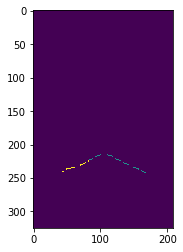

In [11]:
img = training['fissuremask'].iloc[1]
piece = SimpleITK.GetArrayViewFromImage(img)[240,:,:]
plt.imshow(piece)
print("Completeness: ", training['completeness'].iloc[1])
np.unique(piece)

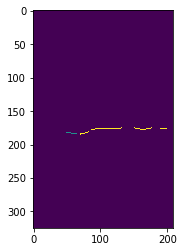

In [12]:
#tom test
img = training['image'].iloc[1]
img_slice = SimpleITK.GetArrayViewFromImage(img)[240,:,:]
plt.imshow(img_slice)
img_msk = training['lungmask'].iloc[1]
img_msk_slice = SimpleITK.GetArrayViewFromImage(img_msk)[140,:,:]
plt.imshow(img_msk_slice)
np.unique(img_msk_slice)
img_fss = training['fissuremask'].iloc[1]
img_fss_slice = SimpleITK.GetArrayViewFromImage(img_fss)[140,:,:]
plt.imshow(img_fss_slice)

lbls = np.array(list(map(SimpleITK.GetArrayViewFromImage,training['fissuremask'].values)))
z, y, x = np.where(np.array(lbls[0]) == 4)

# Create Training and Validation Set

# Patch Generator

During the course we learned to work with a 'patch extractor class', which extracts random patches from a list of images. The benefit from using this class is that it can be used to extract patches **on-the-fly** during training. No pre-constructed dataset is needed, but only a list of training images. This section provides the code of our own ```PatchExtractor``` class.

In [13]:
import matplotlib

In [14]:
'''
PatchExtractor: class used to extract and possibly augment patches from images.
'''

class PatchExtractor:
    
    def __init__(self, patch_size):
        self.patch_size = patch_size
        
    def get_patch(self, image, location):
        '''
        image: a numpy array representing the input image
        location: a tuple with an z, y, and x coordinate
        
        return a 3D patch from the image at 'location', representing the center of the patch
        '''
        
        z, y, x = location
        c, h, w = self.patch_size
        patch = image[int(z-(c/2)):int(z+(c/2)),int(y-(h/2)):int(y+(h/2)),int(x-(w/2)):int(x+(w/2))]
        
        return patch
        
        
        

In [15]:
def patchVisualizer(patch,patch_size):
    matplotlib.rcParams['figure.figsize'] = (20, 20)
    c, h, w = patch_size
    if c%2 == 0:
        f, axes = plt.subplots(2,int(c/2))
    elif c%3 == 0:
        f, axes = plt.subplots(3,int(c/3))
    i = 0
    for ax_row in axes:
        for ax in ax_row:
            ax.imshow(patch[i,:,:])
            ax.scatter(*[p/2 for p in patch_extractor.patch_size[1:]],c='k', alpha=0.5)
            i += 1
    plt.show()

In [16]:
patch_size = (10,10,10)
img_index = 0
location = (10,50,50)
patch_extractor = PatchExtractor(patch_size)

img = training['image'].iloc[img_index]
img_array = SimpleITK.GetArrayViewFromImage(img)

patch = patch_extractor.get_patch(img_array,location)


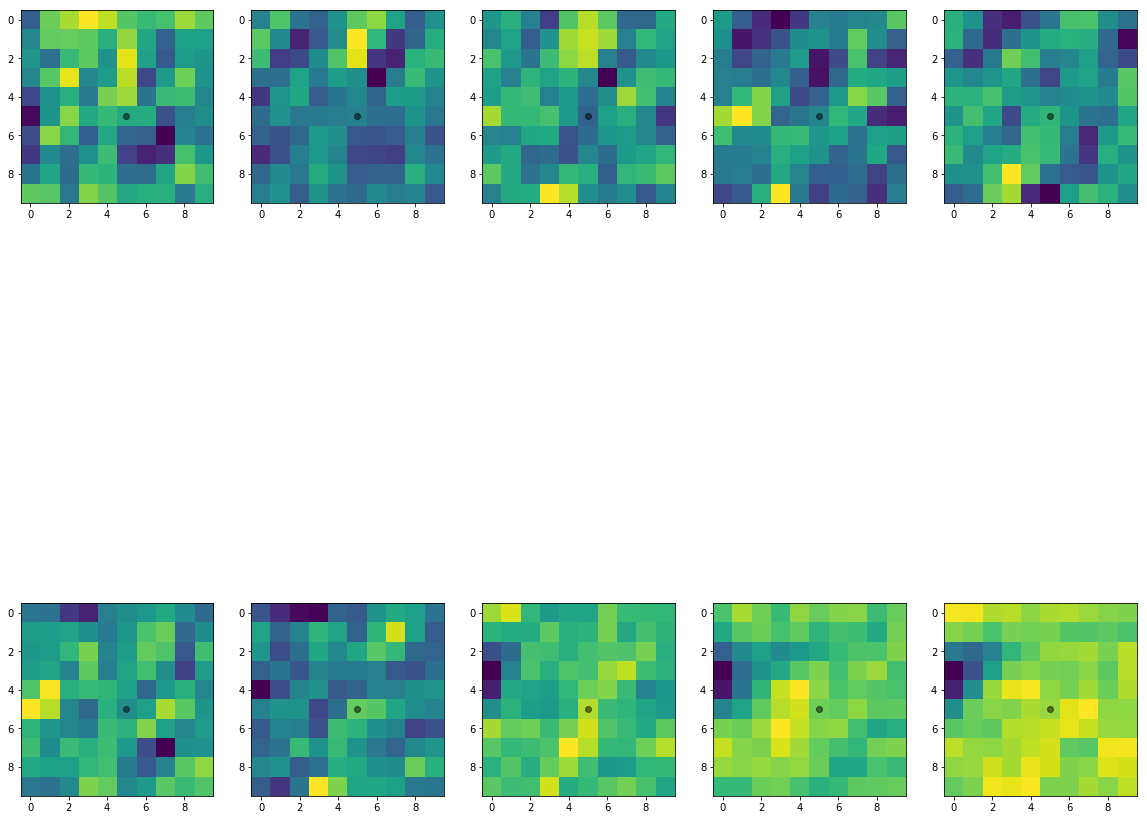

In [17]:
patchVisualizer(patch,patch_size)

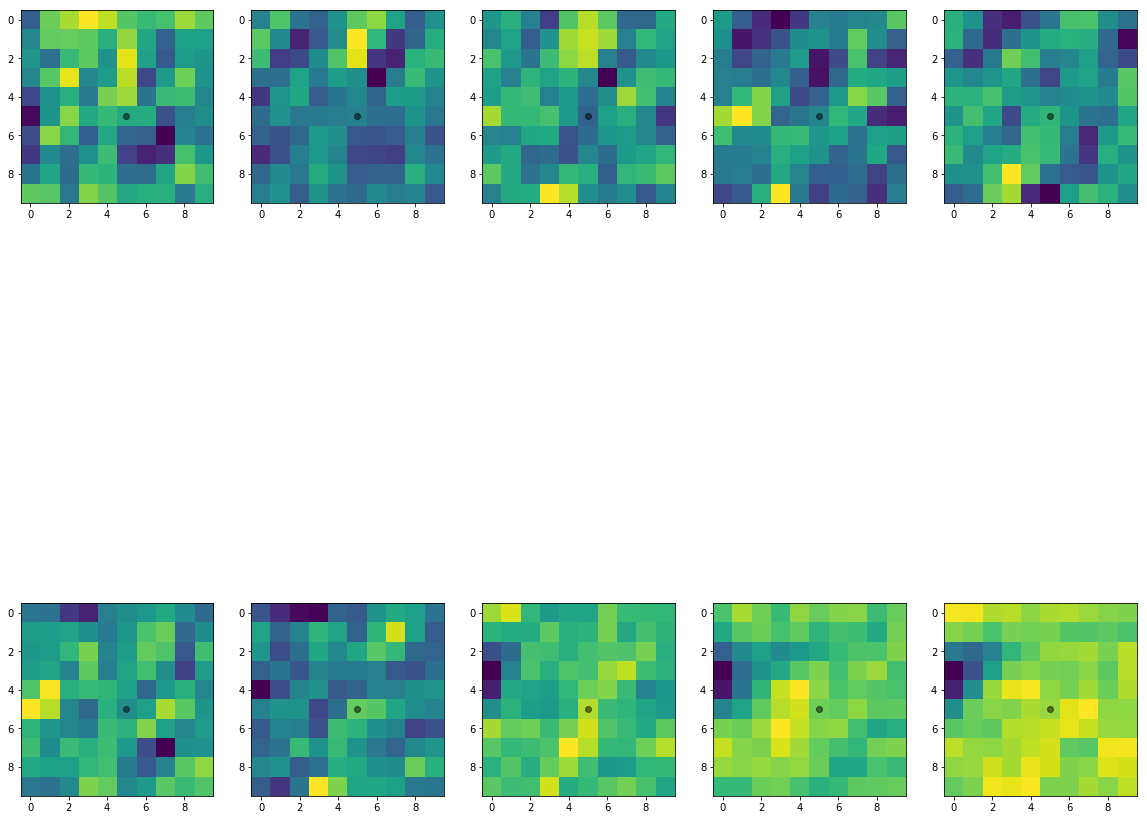

In [18]:
#visualize patch

matplotlib.rcParams['figure.figsize'] = (20, 20)
f, axes = plt.subplots(2, 5)
i = 0;
for ax_row in axes:
    for ax in ax_row:
        ax.imshow(patch[i,:,:])
        ax.scatter(*[p/2 for p in patch_extractor.patch_size[1:]],c='k', alpha=0.5)
        i += 1
plt.show()

# Batch Creator

In [19]:
def get_indices(lbls, msks, category):
    if category == "fissure complete":
        #zyx = [np.where(lbl == 2) for lbl in lbls]
        zyx = []
        for i, lbl in enumerate(lbls):
            zyx.append(np.where((lbl == 2) & (msks[i] == 3)))
        z = [element[0] for element in zyx]
        y = [element[1] for element in zyx]
        x = [element[2] for element in zyx]
        indices = (z,y,x)
    elif category == "fissure incomplete":
        #zyx = [np.where(lbl == 4) for lbl in lbls]
        zyx = []
        for i, lbl in enumerate(lbls):
            zyx.append(np.where((lbl == 4) & (msks[i] == 3)))
        z = [element[0] for element in zyx]
        y = [element[1] for element in zyx]
        x = [element[2] for element in zyx]
        indices = (z,y,x)
    else:
        zyx = []
        for i, lbl in enumerate(lbls):
            zyx.append(np.where((lbl == 0) & (msks[i] == 3)))
        z = [element[0] for element in zyx]
        y = [element[1] for element in zyx]
        x = [element[2] for element in zyx]
        indices = (z,y,x)
    return indices

In [24]:
class BatchCreator:
    
    def __init__(self,patch_extractor,dataset):
        self.patch_extractor = patch_extractor
        
        self.imgs = np.array(list(map(SimpleITK.GetArrayViewFromImage,dataset['image'].values)))
        self.lbls = np.array(list(map(SimpleITK.GetArrayViewFromImage,dataset['fissuremask'].values)))
        self.msks = np.array(list(map(SimpleITK.GetArrayViewFromImage,dataset['lungmask'].values)))
        
        self.a_indices = dataset.index[dataset['label'] == "a"].tolist()
        self.b_indices = dataset.index[dataset['label'] == "b"].tolist()
        self.c_indices = dataset.index[dataset['label'] == "c"].tolist()
        
        
        # pre calculate the fissure complete, fissure incomplete, background indices
        print("get fissure complete indices")
        self.fc_idxs = get_indices(self.lbls, self.msks, "fissure complete")
        print("get fissure incomplete indices")
        self.fi_idxs = get_indices(self.lbls, self.msks, "fissure incomplete")
        print("get background indices")
        self.b_idxs = get_indices(self.lbls, self.msks, "background")
        
    def create_batch(self, batch_size):
        '''
        returns a class-balanced array of patches (x) with corresponding labels (y)
        '''
        
        # unpack the fissure complete, fissure incomplete, and background indices
        fcz, fcy, fcx = self.fc_idxs
        fiz, fiy, fix = self.fi_idxs
        bz, by, bx = self.b_idxs
        
        x_data = np.zeros((batch_size, *self.patch_extractor.patch_size))
        y_data = np.zeros((batch_size, *self.patch_extractor.patch_size))
        
        for i in range(batch_size):
            if i%3 == 0:
                img_index = np.random.choice(self.a_indices+self.b_indices+self.c_indices)
                z, y, x = fcz[img_index], fcy[img_index], fcx[img_index]
                random_index = np.random.choice(len(z))
                location = z[random_index], y[random_index], x[random_index]
                x_data[i] = self.patch_extractor.get_patch(self.imgs[img_index],location)
                y_data[i] = self.patch_extractor.get_patch(self.lbls[img_index],location)
            elif i%2 == 0:
                img_index = np.random.choice(self.a_indices+self.b_indices)
                z, y, x = fiz[img_index], fiy[img_index], fix[img_index]
                random_index = np.random.choice(len(z))
                location = z[random_index], y[random_index], x[random_index]
                x_data[i] = self.patch_extractor.get_patch(self.imgs[img_index],location)
                y_data[i] = self.patch_extractor.get_patch(self.lbls[img_index],location)
            else:
                img_index = np.random.choice(self.a_indices+self.b_indices+self.c_indices)
                z, y, x = bz[img_index], by[img_index], bx[img_index]
                random_index = np.random.choice(len(z))
                location = z[random_index], y[random_index], x[random_index]
                x_data[i] = self.patch_extractor.get_patch(self.imgs[img_index],location)
                y_data[i] = self.patch_extractor.get_patch(self.lbls[img_index],location)
        
        return x_data, y_data
    
    def get_generator(self, batch_size):
        '''returns a generator that will yield batches infinitely'''
        while True:
            yield self.create_batch(batch_size)

In [21]:
#testing batch generator

batch_creator = BatchCreator(patch_extractor, training)

#create batch
x, y = batch_creator.create_batch(28)

get fissure complete indices
get fissure incomplete indices
get background indices
23
25
24
24
37
15
34
42
10


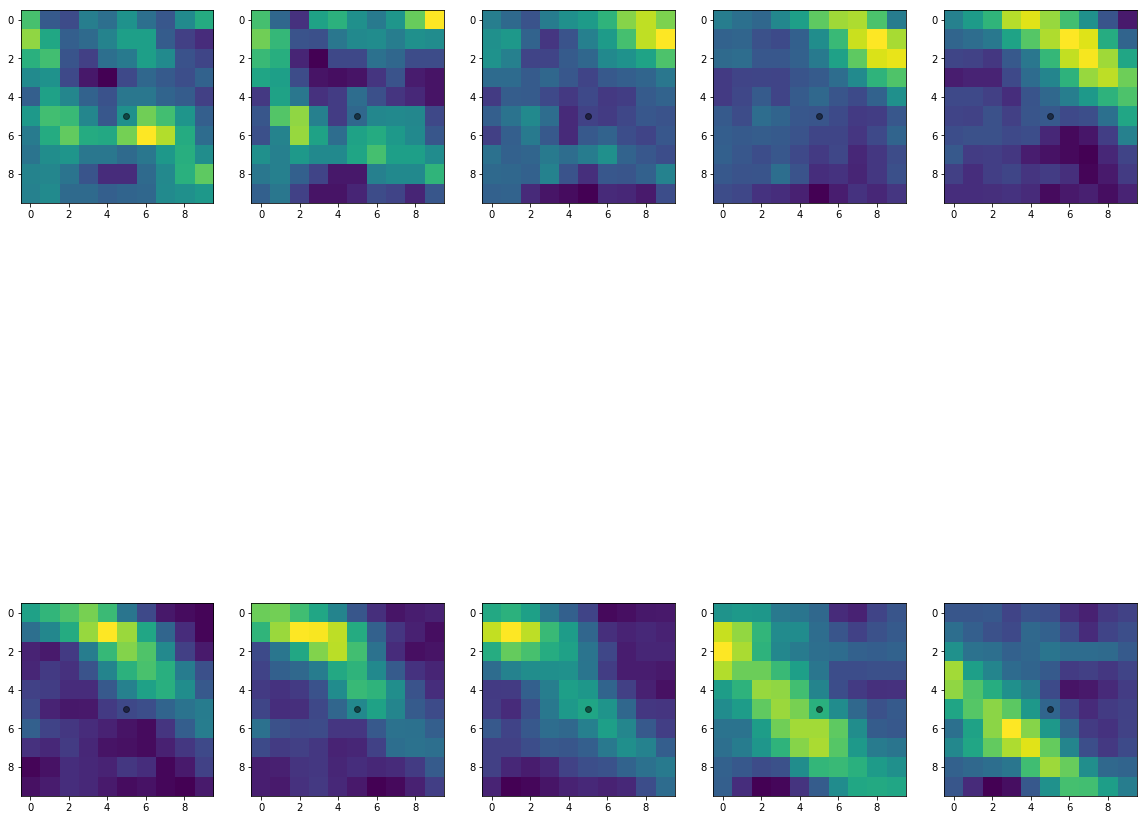

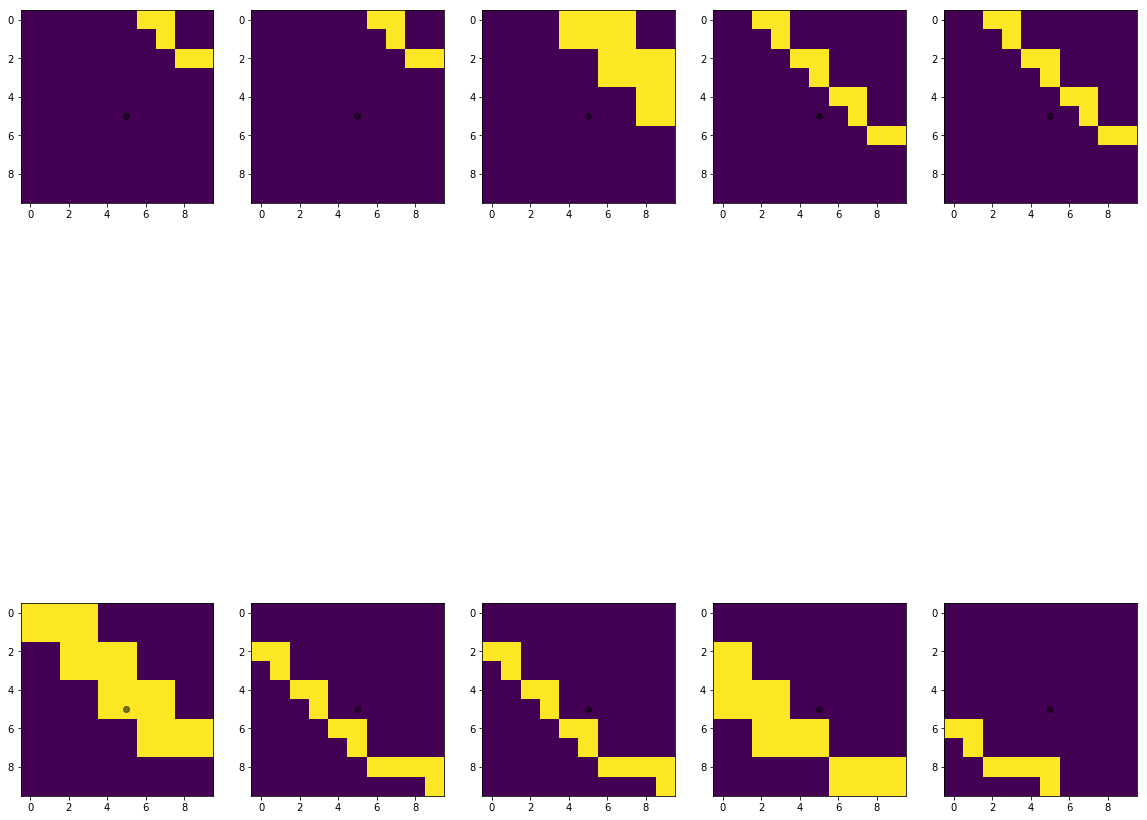

In [23]:
patchVisualizer(x[0],patch_size)
patchVisualizer(y[0],patch_size)

# Network Architecture

# Compiling Model

# Logging